# Building a Single Agent  - with LangGraph

## Table of contents
- [Introduction](#introduction)
- [Prerequisites](#prerequisites)
- [Create Single Agent](#setup)
- [Summary](#summary)

## Introduction
**LangGraph** is an extension of LangChain that provides a framework for building stateful agent applications. This notebook demonstrates how to create a mortgage assistant using LangGraph that can help customers access information about their existing mortgages.

### Objectives

By the end of this notebook, you will:
1. Understand how to create a single agent using LangGraph
2. Learn how to define tools for retrieving mortgage information
3. Implement the ReAct pattern for reasoning and action execution
4. Build a simple conversational interface for mortgage assistance


## Prerequisites

Before starting this notebook, ensure you have:
- Familiarity with LangChain concepts (optional but helpful)
- Basic understanding of Python and Jupyter notebooks
- AWS account with access to Amazon Bedrock and SageMaker


## Setup
Start by installing some of the required packages, including LangChain for pre-built tool components, LangGraph for agent workflows, and other necessary libraries.

In [1]:
%pip uninstall boto3 botocore awscli --yes

Found existing installation: boto3 1.39.2
Uninstalling boto3-1.39.2:
  Successfully uninstalled boto3-1.39.2
Found existing installation: botocore 1.39.2
Uninstalling botocore-1.39.2:
  Successfully uninstalled botocore-1.39.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -r requirements.txt -q --force-reinstall

Note: you may need to restart the kernel to use updated packages.


<div class="alert alert-block alert-info">
<b>Important:</b> restart the kernel before proceeding with the next cells. You can use the restart icon on the top of this notebook or  uncomment below cell and execute
</div>

In [3]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")


Import the following modules

In [4]:
from typing import TypedDict, List, Annotated, Union
from langchain_aws import ChatBedrock, ChatBedrockConverse
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent, ToolNode,tools_condition
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, AnyMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState, StateGraph, START, END
import os
import boto3
from IPython.display import display,Image
import random
from textwrap import dedent
from langchain.tools import tool
from datetime import datetime, timedelta



Next, we setup the LLMs to be used for this lab. Although you will use these specific models for this lab, LangChain also supports models from other [providers](https://python.langchain.com/docs/integrations/chat/#featured-providers)


When setting up an LLM model, you can also set model parameters. In this case, we set `temperature` to 0.7 to balance creativity with accuracy. A higher temperature (closer to 1.0) would produce more creative but potentially less accurate responses, while a lower temperature (closer to 0) would produce more deterministic responses.

If you're running this notebook locally, set the AWS_PROFILE

-----

## Create Your First Agent

Let's start by creating the first agent - the existing mortgage agent. This agent will be responsible for gathering existing loan information for the customer



### Understanding LangGraph

LangGraph comes with a set of prebuilt components that implement common agent behaviors and workflows. These abstractions are built on top of the LangGraph framework, offering a faster path to production while remaining flexible for advanced customization.

LangGraph uses the concept of `StateGraph`, an object that defines the structure as state machine. The Graph has `nodes` and edges :
-  a node can be an LLM or tool/function 
-  en edge is how you specify the nodes are connected and state is transitioned along the graph


First step in creating a graph is to define the state which includes the graph's schema and reducer functions that handle state updates

LangGraph has pre-built `MessageState` that can be imported directly. If you have complex schemas, you can define them accordingly. For this lab, we will use the pre-built State schema

In [5]:
class AgentState(MessagesState):
    pass

Next, we shall define a `get_mortgage_details` function which will be used as a tool for the agent

In [6]:
from datetime import datetime, timedelta

def get_mortgage_details(customer_id: str) -> str:
    """
Retrieves the details about an application for a new mortgage.
The function takes a customer ID, but it is purely optional. The function
implementation can retrieve it from session state instead. Details include
the application ID, application date, application status, application type,
application amount, mortgage interest, and application term in years"""
    return {
        "account_number": customer_id,
        "outstanding_principal": 150599.25,
        "interest_rate": 8.5,
        "maturity_date": "2030-06-30",
        "original_issue_date": "2021-05-30",
        "payments_remaining": 72,
        "last_payment_date": str(datetime.today() - timedelta(days=14)).split(' ')[0],
        "next_payment_due": str(datetime.today() + timedelta(days=14)).split(' ')[0],
        "next_payment_amount": 1579.63
    }

def create_customer_id():

    """
    Creates customer ID"""
    return "123456"

def create_loan_application(customer_id, name, age, annual_income, annual_expense):
    """Creates a new loan application using the details provided. The details include the name,
            age, customer_id, annual_income and annual_expense
            """
    print(f"creating loan application for customer: {customer_id}...")
    print(f"customer name: {name}")
    print(f"customer age: {age}")
    print(f"customer annual income: {annual_income}")
    print(f"customer annual expense: {annual_expense}")
    return {
        "customer_id": customer_id,
        "customer_name": name,
        "age": age,
        "annual_income": annual_income,
        "annual_expense": annual_expense,
        "application_date": datetime.now().strftime("%Y-%m-%d"),
        "message": "Loan application successfully created"
    }
    


def get_mortgage_app_doc_status(customer_id):
    """Retrieves the list of required documents for a mortgage application in process, 
along with their respective statuses (COMPLETED or MISSING). 
The function takes a customer ID, but it is purely optional. The funciton
implementation can retrieve it from session state instead.
This function returns a list of objects, where each object represents 
a required document type. 
The required document types for a mortgage application are: proof of income, employment information, 
proof of assets, and credit information. Each object in the returned list contains the type of the 
required document and its corresponding status."""
    return [
        {
            "type": "proof_of_income",
            "status": "COMPLETED"
        },
        {
            "type": "employment_information",
            "status": "MISSING"
        },
        {
            "type": "proof_of_assets",
            "status": "COMPLETED"
        },
        {
            "type": "credit_information",
            "status": "COMPLETED"
        }
    ]

Once the tool function is defined, we move on to setting up the model. LangGraph uses [init_chat_model()](https://python.langchain.com/docs/how_to/chat_models_universal_init/) helper method to make it easy to initialise different models via respective model providers. 

For the lab, we will use models provided via  Amazon Bedrock. 

Depending on the model availability and the region  you are running this lab, change the agent_foundation_model[] and region_name before instantiating the boto client

In [7]:

agent_foundation_model = [
    'us.anthropic.claude-3-5-haiku-20241022-v1:0'
    ]


bedrock_client = boto3.client('bedrock-runtime',region_name='us-east-1')

print(f"Client region:{bedrock_client.meta.region_name}")

model = init_chat_model(
    agent_foundation_model[0],
    model_provider="bedrock_converse",
    temperature=0.7,
    client=bedrock_client
)

Client region:us-east-1


LangGraph provides both low-level primitives and high-level prebuilt components for building agent-based applications. This section focuses on the prebuilt, reusable components designed to help you construct agentic systems quickly and reliably—without the need to implement `orchestration, memory, or human feedback handling from scratch`

If we were to build using low-level primitives, firstly you define a node, initiate the graph, add nodes and compile the graph:

```# Define the Node
def existing_mortgage_node(state: AgentState):
    # Define the Node
    existing_mortgage_node = existing_mortgage_agent.invoke(state)
    return existing_mortgage_node

graph = StateGraph(AgentState)
graph.add_node("existing_mortgage_agent", existing_mortgage_node)
graph.add_edge(START,"existing_mortgage_agent")
graph.add_edge("existing_mortgage_agent",END)

app = graph.compile()
```

The [create_react_agent](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent) is a high level pre-built component that takes care of this and returns a compiled graph, so we wont need to define the graph, add nodes, and returns the compiled graph 

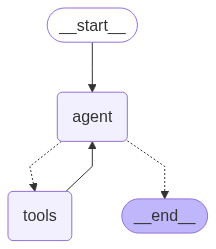

In [8]:
# Define the Agent
system =         """
    You are a mortgage bot for creating, managing, and completing an application for a new mortgage. you greet the customer before your answer.
You first ask customers for their customer id. If they don't have any then you use the tool to create a new customer id and tell the user that you have created a new customer id and show it to them.
Next, you ask for their name, age, annual income and annual expense. Ask one question at a time. If they cant answer any of the questions then its fine, you just move forward. 
Once you have all the information use the tool to create a new loan application for this customer. 
After creating the loan application give the customer their newly created customer id if they didn't provide one initially.
never make up information that you are unable to retrieve from your available actions. 
do not engage with users about topics other than an existing mortgage. leave those other topics for other experts to handle. for example, do not respond to general questions about mortgages. However, respond to the greeting by another greeting
 """
existing_mortgage_agent = create_react_agent(
    model=model,
    tools=[get_mortgage_details,create_customer_id,create_loan_application,get_mortgage_app_doc_status],
    prompt=dedent(system)

)

#visualise the graph
display(Image(existing_mortgage_agent.get_graph().draw_mermaid_png()))

Once the agent is created, we can interact with the agent using `invoke()` or `stream()`. For this lab, we shall use invoke(). For additional methods available for the graph, you can read [here](https://langchain-ai.github.io/langgraph/reference/graphs/)

In [9]:
response = existing_mortgage_agent.invoke(
    {"messages": "Howdy"})

for message in response["messages"]:
    message.pretty_print()

SSLError: SSL validation failed for https://bedrock-runtime.us-east-1.amazonaws.com/model/us.anthropic.claude-3-5-haiku-20241022-v1%3A0/converse [Errno 2] No such file or directory

Now, let's ask the agent to create a loan application 

You can directly pass in the string input for messages in the compiled graph, which will be converted to a `HumanMessage`. This behavior differs from the prompt parameter in create_react_agent, which is interpreted as a `SystemMessage` when passed as a string.

In [ ]:
response = existing_mortgage_agent.invoke(
    {"messages":"I want to apply for a new mortgage. My name is John Smith, I'm 35 years old, earn $75000 annually, and have $25000 in expenses."

}
)

for message in response["messages"]:
    message.pretty_print()

In [ ]:

response = existing_mortgage_agent.invoke(
    {"messages": "Could you remind me what's my mortgage interest rate is?"}
)

for message in response["messages"]:
    message.pretty_print()

You might have noticed that the agent doesn't have any past information. Let's fix that add memory. LangGraph supports two types of memory
- Short-term memory (thread-level memory): tracks message conversations within a single session
- Long-term memory (cross-thread memory): stores conversations across sessions

In today's lab we will be using the short-term memory. For more info you can find it [here](https://langchain-ai.github.io/langgraph/how-tos/memory/)

To set up a memory and use it in the agent, we need to complete two steps:

1. create memory and add it to the `graph.compile()` function
2. supply `thread_id` in the config when invoking the agent


Let's start with import necessary libraries , instantiate the checkpointer and assign it to the `graph.compile()`

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()

existing_mortgage_agent_with_memory = create_react_agent(
    model=model,
    tools=[get_mortgage_details,create_customer_id,create_loan_application,get_mortgage_app_doc_status],
    prompt=dedent(system),
    checkpointer=memory

)


Now lets define the config parameter and add it the invocation. We will use random integer here

In [ ]:
config = {"configurable": {"thread_id": random.randint(1,10000)}}

response = existing_mortgage_agent_with_memory.invoke(
    {"messages":"I want to apply for a new mortgage. My name is John Smith, I'm 35 years old, earn $75000 annually, and have $25000 in expenses."}
    ,config
)

for message in response["messages"]:
    message.pretty_print()

In [ ]:
response = existing_mortgage_agent_with_memory.invoke(
    {"messages": "Could you remind me what's my mortgage interest rate is?"},
    config
) 

for message in response["messages"][-1:]:
    message.pretty_print()

## Summary

In this notebook, we demonstrated how to build a single agent using LangGraph that can handle mortgage-related queries and provide information to customers about their existing mortgages.

Key components covered:
- Basics of LangGraph
- Creating a specialized mortgage agent with the ReAct pattern
- Implementing  tools for retrieving mortgage details
- Retaining memory for the agent

Next, we will move on to Lab 2 where we will cover multi-agent setup, allowing different specialized agents to collaborate and handle more complex mortgage scenarios.